In [1]:
import pandas as pd
import numpy as np
import json
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [2]:
from collections import Counter

In [3]:
df_company = pd.read_csv('datasets/company.csv')

In [4]:
idx_company = {}
for i, com in tqdm(enumerate(df_company['company'].values)):
    idx_company[i] = com

31626it [00:00, 1608920.48it/s]


# Build vocab

In [5]:
vietnamese_vocab, english_vocab, normal_vocab = [], [], []
with open('datasets/vocab/english/Oxford 5000.txt') as f:
    english_vocab = f.readlines()
english_vocab = [w[:-1] for w in english_vocab]
    
with open('datasets/vocab/vietnamese/Viet74K.txt') as f:
    vietnamese_vocab = f.readlines()
vietnamese_vocab = [w[:-1] for w in vietnamese_vocab if len(w.split())==1]

normal_vocab = english_vocab + vietnamese_vocab

In [6]:
len(normal_vocab)

11229

In [7]:
vocab_counter = Counter()
for i, dict_word in tqdm(enumerate(df_company['bow'])):
    vocab_counter += Counter(eval(dict_word))

31626it [46:45, 11.27it/s]


In [12]:
vocab = vocab_counter.most_common(30000)
vocab = [v[0] for v in vocab if v[0] in normal_vocab]

In [14]:
vocab = vocab[:5000]
len(vocab)

5000

In [15]:
vocab_idx = {}
for i, v in enumerate(vocab):
    vocab_idx[v] = i

# Bag of word

In [16]:
content = []
for i in tqdm(range(len(df_company))):
    row = [0]*len(vocab)
    for w, f in eval(df_company['bow'][i]).items():
        if w in vocab_idx:
            idx = vocab_idx[w]
            row[idx] = f
    content.append(row)

100%|██████████| 31626/31626 [02:00<00:00, 261.52it/s]


# TF-IDF

In [17]:
tfidf_vectorizer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_content = tfidf_vectorizer.fit_transform(content).toarray()
print('(Document - vocab): {}'.format(tfidf_content.shape))

(Document - vocab): (31626, 5000)


# SVD

In [18]:
from scipy import linalg

In [19]:
# U: document x topic
# s: topic x topic
# Vh: topic x vocab
U, s, Vh = linalg.svd(tfidf_content, full_matrices=False)

In [20]:
U = np.array(U)
s = np.array(s)
Vh = np.array(Vh)
print(U.shape)
print(Vh.shape)

(31626, 5000)
(5000, 5000)


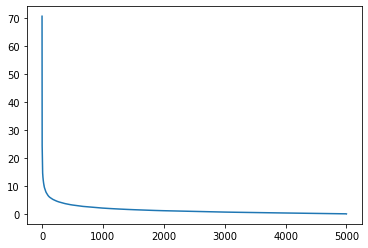

In [21]:
plt.plot(s)

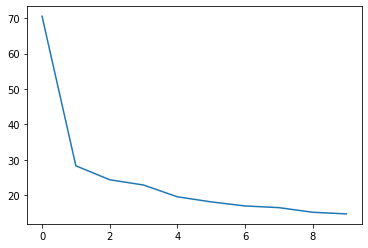

In [22]:
plt.plot(s[:10])

# LSA

In [112]:
import pickle

In [122]:
#with open('docment_topic_matrix.pkl', 'rb') as f:
#    lsa_topic_matrix = pickle.load(f)

In [96]:
def get_topic(doc_top_matrix):
    return doc_top_matrix.argmax(axis=1).tolist()

def count_value_topic(topics):
    count_pair = Counter(topics).items()
    topic = [pair[0] for pair in count_pair]
    freq = [pair[1] for pair in count_pair]
    return (topic, freq)

def get_top_k_word(id_topic, k):
    V = Vh[:n_topic]
    indices = V[id_topic].argsort()[::-1][:k]
    return ' '.join([vocab[i] for i in indices])

In [23]:
from sklearn.decomposition import TruncatedSVD

In [111]:
n_topic = 20
lsa_model = TruncatedSVD(n_components=n_topic)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_content) # (document x topic)

In [97]:
topics = get_topic(lsa_topic_matrix)
topic , frequency = count_value_topic(topics)

In [98]:
topic

[0, 6, 3, 7, 1, 9, 8, 4, 5, 2]

In [99]:
frequency

[27339, 304, 443, 224, 2587, 42, 343, 267, 21, 56]

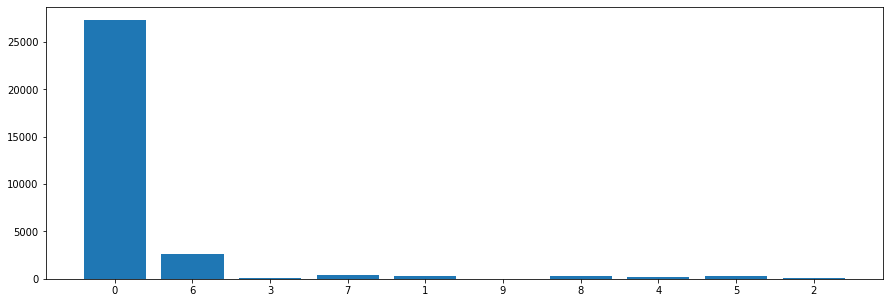

In [100]:
index = np.arange(len(topic))
plt.figure(figsize=(15,5))
plt.xticks(index, topic)
plt.bar(topic, frequency)
plt.show()

In [101]:
for i in range(n_topic):
    print('Topic: {} - {}'.format(i, get_top_k_word(i, 20)))

Topic: 0 - trẽn loom bẽ harmonica smash êtô epsilon phốc trớn totem beneath trệu cụp lesbian hóp phên fare versus flourish nác
Topic: 1 - the to in a s be domain can no co may ward terms ho copyright i content an info t
Topic: 2 - kế nhà công xây thất án dựng thi dự nội thiết tư the căn kiến trúc vụ trình dịch cư
Topic: 3 - máy công thiết thất nhà kế thi tủ nội điện xây hệ dựng phòng bếp bị camera gỗ án liên
Topic: 4 - thất phẩm nội sản hàng giỏ gỗ da kế ghế áo phòng bàn trang bếp ngủ kệ tủ sơn nhà
Topic: 5 - máy thất thiết kế nội xe du bạn tủ hàng khách phòng bếp camera có lịch không ghế bàn đ
Topic: 6 - dịch vụ thiết kế hàng công cáo doanh marketing nghiệp in seo bạn bảo camera quản tôi toán chúng xây
Topic: 7 - máy học da và là có bệnh nước các phẩm thuốc của làm một trong được sinh không dược những
Topic: 8 - camera án dự đèn hình đầu màn thông thiết điện bị bộ căn cáp đăng ghi giỏ ổ đất loa
Topic: 9 - máy hàng án dự in căn đất nhà hộ giỏ tư đăng mua khu cư bất quận bán áo phố


# LDA

In [125]:
from sklearn.decomposition import LatentDirichletAllocation

In [129]:
lda = LatentDirichletAllocation(n_components= n_topic, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(content)

In [133]:
lda_W = lda.transform(content) # docment x topic by LDA
lda_H = lda.components_ # topic x word

In [140]:
lda_W

array([[4.94509974e-04, 1.38194083e-06, 5.48455857e-01, ...,
        1.38194083e-06, 1.46927055e-02, 1.01807324e-02],
       [4.75321328e-07, 4.75321327e-07, 4.75321326e-07, ...,
        4.75321327e-07, 4.75321326e-07, 4.75321321e-07],
       [7.77580807e-07, 3.80127247e-03, 7.29240098e-01, ...,
        7.77580809e-07, 6.01792827e-02, 1.99215587e-02],
       ...,
       [1.61864688e-05, 1.61864687e-05, 1.61864686e-05, ...,
        1.38324336e-02, 3.00279858e-02, 4.16330230e-01],
       [4.69708690e-03, 2.67425541e-03, 1.01424228e-03, ...,
        4.43525607e-02, 5.91243241e-02, 3.09876847e-03],
       [3.36179664e-06, 3.36179662e-06, 1.75852520e-01, ...,
        3.36179663e-06, 3.10657813e-02, 1.52967242e-03]])

## Save matrix

In [141]:
with open('document_topic_matrix_lda.pkl', 'wb') as f:
    pickle.dump(lda_W ,f)
with open('topic_vocab_matrix_lda.pkl', 'wb') as f:
    pickle.dump(lda_H,f)

In [142]:
with open('document_topic_matrix_lda.pkl', 'rb') as f:
    w = pickle.load(f)

In [144]:
with open('topic_vocab_matrix_lda.pkl', 'rb') as f:
    h = pickle.load(f)

In [136]:
lda_H.shape

(20, 5000)

# Evaluate

In [61]:
index = np.arange(len(lsa_topic_matrix))
df_com = pd.DataFrame({'com': [idx_company[i] for i in index] , 'topic': topics})

In [62]:
df_com.loc[df_com['topic']==4]

,com,topic
233,0900609115,4
318,0303974996,4
817,0314639929,4
843,0315515531,4
1336,0312253408,4
1386,0304950074,4
1488,0311020961,4
1513,0311779124,4
1579,0315197688,4
1680,0315937004,4


In [52]:
from sklearn.metrics.pairwise import cosine_similarity

In [53]:
cosine_matrix = cosine_similarity(tfidf_content)

In [63]:
def get_k_similarity(id_com, k):
    similarity = cosine_matrix[id_com].argsort()[::-1][:k]
    return [idx_company[i] for i in similarity]

In [64]:
get_k_similarity(0, 10)

['0316128101',
 '0309503376',
 '0309514882',
 '0107559947',
 '0312950568',
 '0313035018',
 '0104166095',
 '0316346999',
 '0315788810',
 '0107857703']

In [110]:
df_company['bow'].loc[df_company['company']=='0316128101']

0    Counter({'học': 1614, 'và': 714, 'trường': 659...
Name: bow, dtype: object